In [40]:
%run "/Users/chiaentsai/Desktop/lab/Temperature_Calibration/curve_fit_.ipynb"
%run "/Users/chiaentsai/Desktop/lab/Temperature_Calibration/data_processing_.ipynb"
%run "/Users/chiaentsai/Desktop/lab/Temperature_Calibration/evaluation_functions_.ipynb"
%run "/Users/chiaentsai/Desktop/lab/Temperature_Calibration/fitting_functions_.ipynb"
%run "/Users/chiaentsai/Desktop/lab/Temperature_Calibration/get_temperature_.ipynb"

In [41]:
from pathlib import Path
from enum import Enum
import cv2
from cv2 import imwrite
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from time import time
from scipy.optimize import curve_fit
%matplotlib inline
import scipy.stats
from util import parse_fn, is_bg
from scipy import stats
from scipy.stats import skewnorm
from scipy.special import erf
from scipy.special import voigt_profile

# information of picture

In [42]:
HEADER_LEN = 152 
X_DIM = 1200 
Y_DIM = 1920

# Input Files

### input needed: 

### 1. name of the folder containing different velocity's picture

### 2. velovity we measure (todo: don't need this!) 

In [43]:
folder = "/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/chess_2022_2_0412/TR_0412"

In [44]:
import os
from pathlib import Path
v_path_list = []
for root, dirs, files in os.walk(folder, topdown=False):
    for name in dirs:
        v_path_list.append(os.path.join(root, name))
        
big_list = []
for item in v_path_list:
    p_pathlist = Path(item).glob('**/*.raw')
    p_path_list = []
    for path in p_pathlist:
        p_path_list.append(path)
    big_list.append(p_path_list)
    
Dict = {103: big_list[0], 
        13: big_list[1],
        155: big_list[2],
        190: big_list[3],
        20: big_list[4],
        234: big_list[5],
        30: big_list[6],
        352: big_list[7],
        45: big_list[8],
        68: big_list[9],
        9: big_list[10],
       }

frame_num = []
for i in list(Dict.keys()):
    frame_num.append(round(5/i*40+1))

import os
b_files = []
all_v_files = []
for i in range(0,len(frame_num), 1):
    files=[]
    for file in os.listdir(v_path_list[i]):
        if file.endswith("_00{}.raw".format(frame_num[i])) or file.endswith("_0{}.raw".format(frame_num[i])):
            name = str(os.path.join(v_path_list[i], file))
            files.append(name)
    all_v_files.append(files)
    b_files.append(files[0])
    
Dict_new = {103: all_v_files[0], 
        13: all_v_files[1],
        155: all_v_files[2],
        190: all_v_files[3],
        20: all_v_files[4],
        234: all_v_files[5],
        30: all_v_files[6],
        352: all_v_files[7],
        45: all_v_files[8],
        68: all_v_files[9],
        9: all_v_files[10],
       }

# Visualization

### 5mm frame figures

In [45]:
for v in list(Dict_new.keys()):
    for i, item in enumerate(Dict_new[v]):
        fig = get_blue(item)
        plt.imshow(fig)
        plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/5mm_frame_figure/{}mm_5mmframe_{}.png".format(v,i), format="PNG")
        plt.close()

### 5mm frame figures (no background)

In [46]:
for I, v in enumerate(list(Dict_new.keys())):
    for i, item in enumerate(Dict_new[v]):
        original = get_blue(item)
        back = get_blue(b_files[I])
        fig = original - back
        plt.imshow(fig)
        plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/noback_5mm_frame_figure/{}mm_5mmframe_{}.png".format(v,i), format="PNG")
        plt.close()

### All frame figures (no background)

In [ ]:
'''
for I, v in enumerate(list(Dict.keys())):
    for i, item in enumerate(Dict[v]):
        original = get_blue(item)
        back = get_blue(b_files[I])
        fig = original - back
        plt.imshow(fig)
        plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/noback_all_frame_figure/{}mm_{}.png".format(v,i), format="PNG")
        plt.close()
'''

# Get kappa (gold melt)

### input needed: gold melting power at specific velocity 

In [47]:
gold_melt = [54,58,45,49.5,52,42.5]
Dict_used = {103: all_v_files[0], 
        155: all_v_files[2],
        20: all_v_files[4],
        45: all_v_files[8],
        68: all_v_files[9],
        9: all_v_files[10],
       }

In [48]:
Dict_gold = {k: Dict_used[k][1:] for k in Dict_used}
b_files_gold = [b_files[i] for i in [0,2,4,8,9,10]]
Dict_dRoverR = dict.fromkeys(list(Dict_gold.keys()),[])

dRoverR = []
for i, v in enumerate(list(Dict_gold.keys())):
    con = []
    for file in Dict_gold[list(Dict_gold.keys())[i]]:
        val = peak_dRoverR(file, b_files_gold[i], poly5, poly5)
        con.append(val)
    dRoverR.append(con)
    
power=[]
for i, v in enumerate(list(Dict_gold.keys())):
    con = np.linspace(29,29+2*(len(Dict_gold[v])-1),(len(Dict_gold[v])-1)+1)
    power.append(con)
powers = [i.astype(int) for i in power]

### visualization and fitting

In [49]:
for i, v in enumerate(list(Dict_gold.keys())):
    plt.plot(powers[i], dRoverR[i], '.')
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/gold_dRoverR_figure/{}mm.png".format(v), format="PNG")
    plt.close()

In [50]:
kappa_gold = []
for i, v in enumerate(list(Dict_gold.keys())):
    popt, pcov = curve_fit(expo, powers[i], dRoverR[i], p0 = [1, 0.0000001, 1], maxfev = 5000)
    plt.plot(powers[i], dRoverR[i], '.')
    plt.plot(powers[i], expo(powers[i], *popt))
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/gold_dRoverR_fit_figure/{}mm.png".format(v), format="PNG")
    plt.close()
    a, b, c = popt
    y_pred = expo(powers[i], *popt)
    f = expo(gold_melt[i], *popt)
    gold_m = 1064
    dT = gold_m - 25
    kappa = f / dT
    kappa_gold.append(kappa)

In [51]:
Dict_kappa_gold = dict(zip(list(Dict_gold.keys()),kappa_gold))

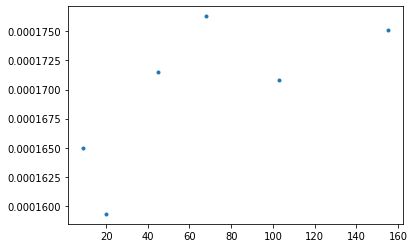

In [52]:
plt.plot(list(Dict_gold.keys()), kappa_gold, '.')

In [53]:
avg_kappa_gold = sum(kappa_gold) / len(kappa_gold)

# Get kappa (silicon melt)

### input need: si melting power at specific velocity

In [14]:
si_melt = [49.75, 51.5, 53.5, 56, 48.5]
Dict_used = { 13: all_v_files[1],
        20: all_v_files[4],
        30: all_v_files[6],
        45: all_v_files[8],
        9: all_v_files[10],
       }

In [15]:
Dict_si = {k: Dict_used[k][1:] for k in Dict_used}
b_files_si = [b_files[i] for i in [1,4,6,8,10]]
Dict_dRoverR = dict.fromkeys(list(Dict_si.keys()),[])

dRoverR = []
for i, v in enumerate(list(Dict_si.keys())):
    con = []
    for file in Dict_si[list(Dict_si.keys())[i]]:
        val = peak_dRoverR(file, b_files_si[i], poly5, poly5)
        con.append(val)
    dRoverR.append(con)
    
power=[]
for i, v in enumerate(list(Dict_si.keys())):
    con = np.linspace(29,29+2*(len(Dict_si[v])-1),(len(Dict_si[v])-1)+1)
    power.append(con)
powers = [i.astype(int) for i in power]

### visualization and fitting

In [16]:
for i, v in enumerate(list(Dict_si.keys())):
    plt.plot(powers[i], dRoverR[i], '.')
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/si_dRoverR_figure/{}mm.png".format(v), format="PNG")
    plt.close()

In [17]:
kappa_si = []
for i, v in enumerate(list(Dict_si.keys())):
    popt, pcov = curve_fit(expo, powers[i], dRoverR[i], p0 = [1, 0.0000001, 1], maxfev = 5000)
    plt.plot(powers[i], dRoverR[i], '.')
    plt.plot(powers[i], expo(powers[i], *popt))
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/si_dRoverR_fit_figure/{}mm.png".format(v), format="PNG")
    plt.close()
    a, b, c = popt
    y_pred = expo(powers[i], *popt)
    f = expo(si_melt[i], *popt)
    si_m = 1410
    dT = si_m - 25
    kappa = f / dT
    kappa_si.append(kappa)

In [18]:
Dict_kappa_si = dict(zip(list(Dict_si.keys()),kappa_si))

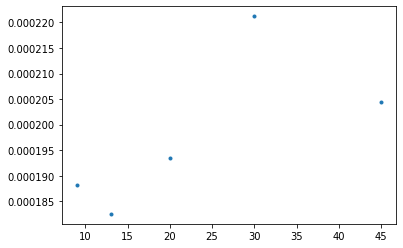

In [19]:
plt.plot(list(Dict_si.keys()), kappa_si, '.')

# T vs frame

In [166]:
v = 45
w = 31

Text(0, 0.5, 'temperature')

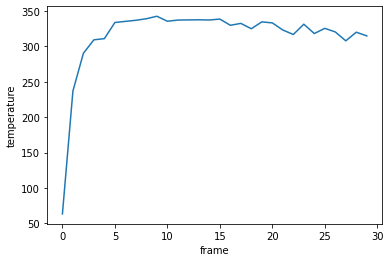

In [167]:
import glob, os
os.chdir(v_path_list[list(Dict.keys()).index(v)])
paths = []
for file in glob.glob("*{}W*".format(w)):
    file = v_path_list[list(Dict.keys()).index(v)] + "/" + file
    paths.append(file)
paths = paths[1:]
frame_tem = []
for path in paths:
    val = get_peak_T(path, b_files[list(Dict.keys()).index(v)], poly5, poly5, avg_kappa_gold)
    frame_tem.append(val)

plt.plot(frame_tem)
plt.xlabel("frame")
plt.ylabel("temperature")

In [175]:
tem = []
for i in range(0,len(Dict)):
    os.chdir(v_path_list[i])
    con = []
    for file in glob.glob("*{}W*".format(w)):
        fi = v_path_list[i] + "/" + file
        con.append(fi)
    con = con[1:]
    frame_tem = []
    for path in con:
        val = get_peak_T(path, b_files[i], poly5, poly5, avg_kappa_gold)
        frame_tem.append(val)
    tem.append(frame_tem)

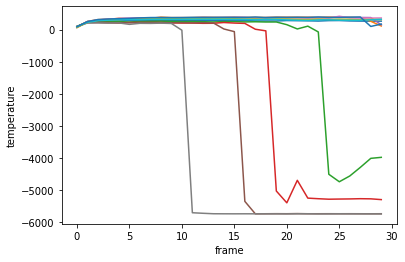

In [177]:
for item in tem:
    plt.plot(item)
    plt.xlabel("frame")
    plt.ylabel("temperature")

# Fit plane